In [1]:
#Main code framework to run a basic crosscorrelation-based auditory model.
#Sarah Verhulst, Arthur Van Den Broucke, Deepak Baby, UGent, 2021

import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
# from tl_model import tl_cochlea
from filters import (erb_point,erb_space,centre_freqs,make_erb_filters,erb_filterbank,gammatone_analysis,pow_stft,hz2mel,mel2hz,mel_fb,mel_analysis)
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from signal_utils import *
%matplotlib inline
import sounddevice as sd
import soundfile as sf

#Parameters for the GT filterbank
fmin = 50. #lowest frequency simulated for GT
numbands = 64 #number of GT bands

HRTF , fsHRTF =sf.read('IRC_1023_C_R0195_T030_P000.wav')
fs, x = sio_wav.read('example.wav')
x=x/max(abs(x))

sd.play(x, fs)

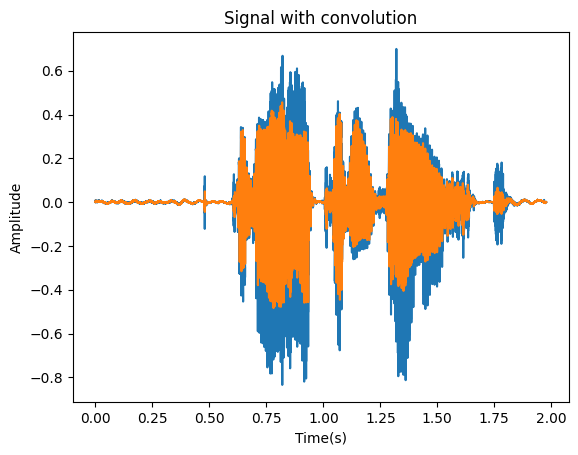

In [3]:
#Use np.convolve to filter the monaural x signal to 
#call the output sig, which should have dimensions (samples,2)
#and make a time t vector of the same length
#plot your result and listen over headphones to the result, does it sound lateralized?


# print(f"x: {x.shape}\nHRTF: {HRTF.shape}")
n_samp = len(x) + len(HRTF)
sig = np.zeros((n_samp-1, 2))
sig[:,0] = np.convolve(x, HRTF[:,0])
sig[:,1] = np.convolve(x, HRTF[:,1])

t = np.arange(len(sig)) / fs # time array

plt.figure()
plt.plot(t, sig[:,0])
plt.plot(t, sig[:,1])
plt.title("Signal with convolution")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
# sd.play(x, fs)
sd.play(sig, fs)

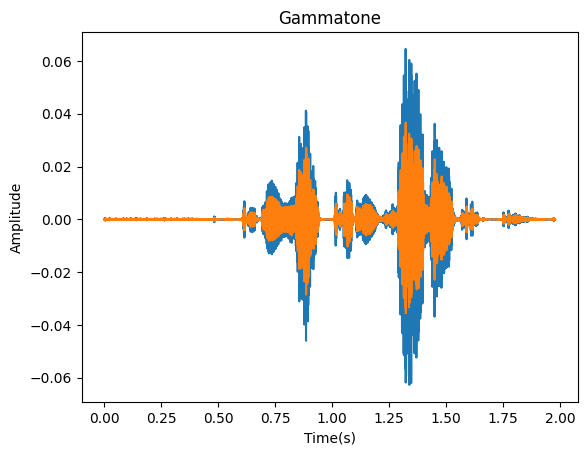

In [8]:
#Next run the code through two monaural GT filterbanks, and plot the 1 kHz (42) channel
gt_out = gammatone_analysis(sig[:,0], fs, numbands, fmin)
gt_L = gt_out['bmm']

gt_out = gammatone_analysis(sig[:,1], fs, numbands, fmin)
gt_R = gt_out['bmm']

plt.figure()
plt.plot(t, gt_L[42,:])
plt.plot(t, gt_R[42,:])
plt.title("Gammatone")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

# sd.play(gt_L[42,:], fs)
sd.play(gt_R[42,:], fs)

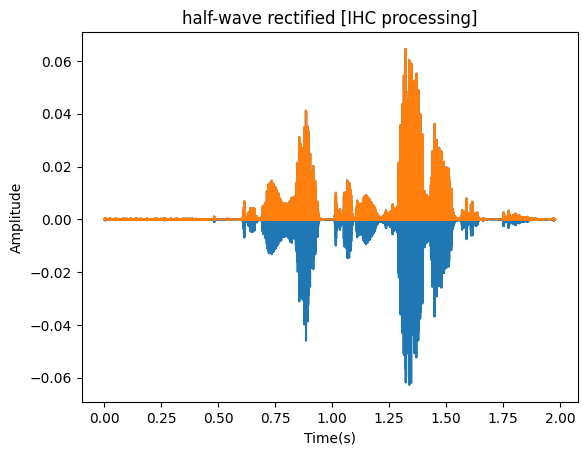

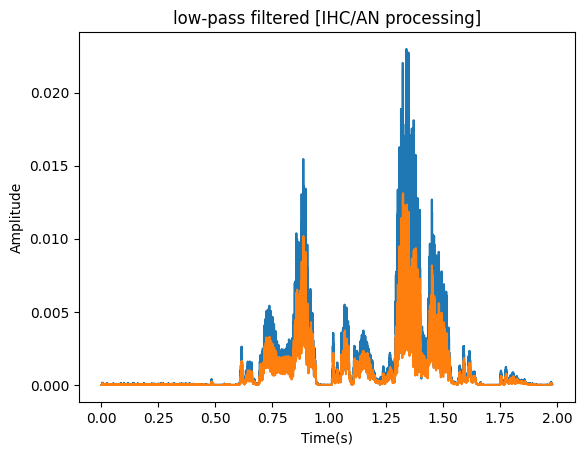

In [10]:
#To mimic the biophysics of auditory processing associated with the cochlear sensory cells (inner-hair-cell) 
#and auditory nerve synapses, first a half-wave rectification is applied, after which a low-pass filtering is conducted
#which functionally models the physiology observation that for carrier frequencies under 1 kHz the signals-phase 
#information is kept while it is removed for carrier frequencies above 1 kHz (i.e., the auditory phase-locking limit). 
#index 42 corresponds to the band with a 1-kHz center frequency

#%rectification
rec_L = gt_L * (gt_L > 0)
rec_R = gt_R * (gt_R > 0)

plt.figure()
plt.plot(t, gt_L[42,:])
plt.plot(t, rec_L[42,:])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title('half-wave rectified [IHC processing]')

fCut=1000

#LP filtering
from scipy.signal import fftconvolve, lfilter
beta=np.exp(-fCut/fs)
IHC_L=lfilter([1-beta],[1, -beta], rec_L, axis=1)
IHC_R=lfilter([1-beta],[1, -beta], rec_R, axis=1)

plt.figure()
plt.plot(t, IHC_L[42,:])
plt.plot(t, IHC_R[42,:])
plt.title('low-pass filtered [IHC/AN processing]')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

[[2.53311094e-10 1.44207225e-09 4.21247026e-09 ... 1.89709078e-06
  4.60937797e-06 6.44674190e-06]]
dict_keys(['cf', 'bmm'])


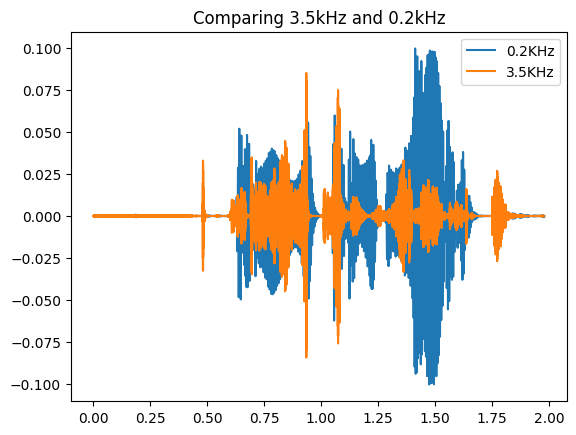

In [26]:
# Make a figure which compares the outputs of gammatone filter with output at 3.5 kHz and compare it to the
# gammatone filter with output at 0.2 kHz, do you observe the phase-locking properties? You can zoom in by using np.xlim
# To get the model-band index corresponding to a filters center frequency (i.e. characteristic frequency)
# you can adopt the following command: Ch1k_gt = np.abs(gt_out['cf'] - CFdes).argmin()    , where "CFdes [Hz]" 
# corresponds to the desired frequency

CFdes_35 = 3500 #Hz
CFdes_02 = 200 #Hz

Ch35 = np.argmin(np.abs(gt_out['cf'] - CFdes_35))
Ch02 = np.argmin(np.abs(gt_out['cf'] - CFdes_02))

#Next run the code through two monaural GT filterbanks, and plot the 1 kHz (42) channel
gt_out_3kHz = gammatone_analysis(sig[:,0], fs, 1, gt_out['cf'][Ch35])
gt_3kHz = gt_out_3kHz['bmm']

gt_out_02kHz = gammatone_analysis(sig[:,1], fs, 1, gt_out['cf'][Ch02])
gt_02kHz = gt_out_02kHz['bmm']

# plt.figure()
# plt.plot(t, gt_L[42,:])
# plt.plot(t, gt_R[42,:])
# plt.title("Gammatone")
# plt.xlabel("Time(s)")
# plt.ylabel("Amplitude")
# plt.show()


print(gt_3kHz)
# print(gt_out['cf'][Ch35])
print(gt_out.keys())

# plotting
plt.plot(t, gt_02kHz[0], label="0.2KHz")
plt.plot(t, gt_3kHz[0], label="3.5KHz")
plt.title("Comparing 3.5kHz and 0.2kHz")
plt.legend()
plt.show()

# sd.play(gt_02kHz, fs)
# sd.play(gt_3kHz, fs)
# print(f"cf -> ch35: {gt_out['cf'][Ch35]}")
# print(f"Ch3.5kHz: {Ch35}\nCh0.2kHz: {Ch02}")

In [ ]:
#This figure shows the frequency spectra before and after applying the filtering, 
#to validate the success of the filtering

plt.figure()
ps = 2*abs(np.fft.fft(rec_L[42,:])/len(rec_L[42,:]))**2
freq_vect = np.fft.fftfreq(len(rec_L[42,:]), d=1/fs)
plt.plot(freq_vect[:int(len(rec_L[42,:])/2)], 10*np.log10(ps[:int(len(rec_L[42,:])/2)]))

ps = 2*abs(np.fft.fft(IHC_L[42,:])/len(IHC_L[42,:]))**2
freq_vect = np.fft.fftfreq(len(IHC_L[42,:]), d=1/fs)
plt.plot(freq_vect[:int(len(IHC_L[42,:])/2)], 10*np.log10(ps[:int(len(IHC_L[42,:])/2)]))
plt.legend(["before filtering","After filtering"])
plt.xlim((0, 2000))
plt.show()

In [ ]:
#compute the interaural cross-correlation at each frequency band
maxLag = int(0.001*fs)
nCh = gt_L.shape[0]
Nx = 10000 #gt_L.shape[1]
iaccFuncts = np.zeros((2*maxLag+1, nCh))
itdEst = np.zeros(nCh)
lags = np.arange(-maxLag, maxLag + 1)
lagValues = lags/fs
for freqInd in range(nCh):
    c = np.correlate(IHC_L[freqInd,:Nx], IHC_R[freqInd,:Nx], mode=2)
    #perform the crosscorrelation between the different CF channels
    iaccFuncts[:,freqInd] = c[Nx - 1 - maxLag:Nx + maxLag]
    # compute the ITD estimate at different frequency bands based on the maxima
    # of the IACC functions in a certain time around time = 0, note that c=symmetrical around 0.
    itdEst[freqInd] = lagValues[iaccFuncts[:,freqInd].argmax()] # argmax() ==> index of the max 

In [ ]:
## plotting of the figures
plt.figure()
plt.semilogx(np.round(gt_out['cf']), itdEst*1000, 'k')
plt.ylabel('Estimated ITD [ms]')
plt.xlabel('Characteristic Frequency [Hz]')
#Around which location do most channels locate the source based on the ITD? Is it the left or right ear? 
#negative delays mean that R was phase delayed over L.

In [ ]:
#Now make a code which computes the ILD difference between the different channels and ears
#You can compute the Level in each channel by computing the rms level in each channel. 
#Is the ILD estimate consistent with your ITD estimate of the source location?
#You can modify the for-loop code from the cell above